In [30]:
# Célula 1: Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, roc_auc_score
from google.colab import files

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [ ]:
# Célula 2: Fazer o upload do arquivo bootcamp_train
print("Por favor, faça o upload do arquivo 'bootcamp_train.csv'")
uploaded_train = files.upload()

print("\nUpload do 'bootcamp_train.csv' concluído!")

Por favor, faça o upload do arquivo 'bootcamp_train.csv'


Saving bootcamp_train.csv to bootcamp_train (1).csv

Upload do 'bootcamp_train.csv' concluído!


In [31]:
# Célula 2.5: Carregar os dados do arquivo para o DataFrame
import io

# Extrai o nome do arquivo do dicionário 'uploaded_train'
train_filename = list(uploaded_train.keys())[0]

# Usa o pandas para ler o arquivo carregado e criar o DataFrame 'df_train'
df_train = pd.read_csv(io.BytesIO(uploaded_train[train_filename]))

print(f"Arquivo '{train_filename}' carregado com sucesso no DataFrame 'df_train'.")

Arquivo 'bootcamp_train (1).csv' carregado com sucesso no DataFrame 'df_train'.


In [32]:
# Célula 3: Diagnóstico Completo do DataFrame de Treino

print("Executando diagnóstico completo do arquivo de treino...")
print("-" * 50)

# 1. Formato dos dados
print("Formato dos dados:")
print(" - df_train:", df_train.shape)
print()

# 2. Nomes das colunas
print("Colunas encontradas:")
print(list(df_train.columns))
print()

# 3. Tipos de dados (dtypes)
print("Tipos de dados (dtypes) por coluna:")
print(df_train.dtypes.sort_index())
print()

# 4. Separação de colunas numéricas e categóricas
num_cols = df_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train.select_dtypes(exclude=np.number).columns.tolist()
print(f"Colunas Numéricas ({len(num_cols)}):", num_cols)
print(f"Colunas Categóricas ({len(cat_cols)}):", cat_cols)
print()

# 5. Contagem de valores ausentes (NaN)
print("Colunas com mais valores ausentes:")
missing = df_train.isna().sum().sort_values(ascending=False)
print(missing[missing > 0]) # Mostra apenas as colunas que de fato têm valores ausentes
print()

# 6. Verificação de linhas duplicadas
dup = int(df_train.duplicated().sum())
print(f"Linhas duplicadas encontradas: {dup}")
print()

# 7. Estatísticas básicas das variáveis numéricas
print("Estatísticas das variáveis numéricas:")
stats = df_train[num_cols].describe().T[['mean','std','min','max']]
print(stats)
print()

# 8. Cardinalidade das variáveis categóricas (quantos valores únicos)
print("Cardinalidade das variáveis categóricas:")
card = df_train[cat_cols].nunique().sort_values(ascending=False)
print(card)
print()

# 9. Análise das Colunas-Alvo (Targets)
print("Análise das Colunas-Alvo:")
# Adaptamos a lista para as colunas reais do nosso projeto
TARGET_COLS = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
]

present_targets = [c for c in TARGET_COLS if c in df_train.columns]

if present_targets:
    print("Alvos encontrados:", present_targets)
    for t in present_targets:
        vc = df_train[t].value_counts(dropna=False)
        total = vc.sum()
        print(f"\n— Distribuição de '{t}':")
        for k, v in vc.items():
            pct = 100.0 * v / total
            print(f"    {str(k):<10}: {v:>6} ({pct:.2f}%)")
else:
    print("Nenhuma das colunas-alvo do projeto foi encontrada.")

print("-" * 50)
print("Diagnóstico concluído.")

Executando diagnóstico completo do arquivo de treino...
--------------------------------------------------
Formato dos dados:
 - df_train: (35260, 15)

Colunas encontradas:
['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

Tipos de dados (dtypes) por coluna:
FA (Falha Aleatoria)                object
FDC (Falha Dissipacao Calor)        object
FDF (Falha Desgaste Ferramenta)     object
FP (Falha Potencia)                 object
FTE (Falha Tensao Excessiva)          bool
desgaste_da_ferramenta             float64
falha_maquina                       object
id                                   int64
id_produto                          object
temperatura_ar                     float64
temperatura_processo               float64
ti

Limpeza e Preparação dos Dados (Focado no df_train

In [33]:
# Célula 4: Limpeza e Preparação dos Dados (Focado no df_train)

print("Iniciando a limpeza dos dados de treino...")

# 1. Limpar colunas de falha (targets)
colunas_para_limpar = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
]

mapa_valores = {
    'sim': 1, 'Sim': 1, 'y': 1, '1': 1, 1: 1, True: 1,
    'não': 0, 'Não': 0, 'N': 0, '0': 0, 0: 0, False: 0, 'n': 0
}

# Aplicar a limpeza apenas no df_train
for col in colunas_para_limpar:
    if col in df_train.columns: # Checa se a coluna existe antes de limpar
        df_train[col] = df_train[col].replace(mapa_valores)
        # Converte para numérico, tratando erros e preenchendo o que sobrar com 0
        df_train[col] = pd.to_numeric(df_train[col], errors='coerce').fillna(0).astype(int)

print("\nColunas de falha limpas. Verificando 'falha_maquina':")
print(df_train['falha_maquina'].value_counts())

# 2. Preencher dados faltantes nas features numéricas
numeric_features = ['temperatura_ar', 'temperatura_processo', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

for col in numeric_features:
    # Preenche valores faltantes com a mediana da coluna
    # Usar a mediana é mais robusto a outliers
    mediana = df_train[col].median()
    df_train[col].fillna(mediana, inplace=True)

print("\nValores nulos preenchidos. Verificando novamente as informações:")
df_train.info()
print("\nLimpeza de dados concluída!")

Iniciando a limpeza dos dados de treino...


/tmp/ipython-input-453387712.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[col] = df_train[col].replace(mapa_valores)



Colunas de falha limpas. Verificando 'falha_maquina':
falha_maquina
0    34598
1      662
Name: count, dtype: int64

Valores nulos preenchidos. Verificando novamente as informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               35260 non-null  int64  
 1   id_produto                       35260 non-null  object 
 2   tipo                             35260 non-null  object 
 3   temperatura_ar                   35260 non-null  float64
 4   temperatura_processo             35260 non-null  float64
 5   umidade_relativa                 35260 non-null  float64
 6   velocidade_rotacional            35260 non-null  float64
 7   torque                           35260 non-null  float64
 8   desgaste_da_ferramenta           35260 non-null  float64
 9   falha_maquina        

/tmp/ipython-input-453387712.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[col] = df_train[col].replace(mapa_valores)
/tmp/ipython-input-453387712.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(mediana, inplace=True)


Análise Exploratória de Dados (EDA) com Dados Limpos

Iniciando a Análise Exploratória de Dados...
--------------------------------------------------

Gráfico 1: Distribuição da 'falha_maquina'


/tmp/ipython-input-937181592.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=falha_counts.index, y=falha_counts.values, palette='viridis')


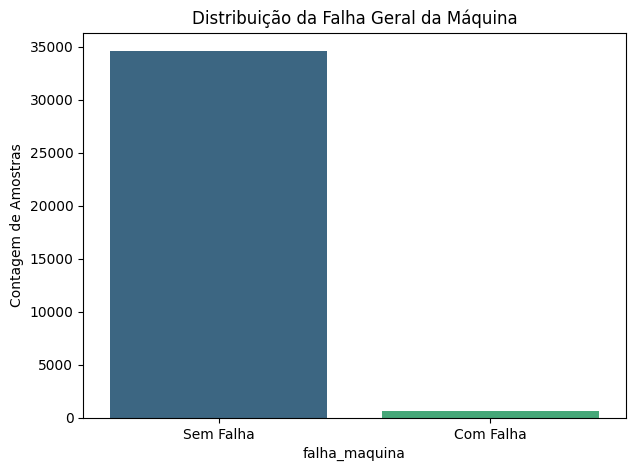


Gráfico 2: Contagem por Tipo Específico de Falha


/tmp/ipython-input-937181592.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=falhas_especificas.index, y=falhas_especificas.values, palette='crest')


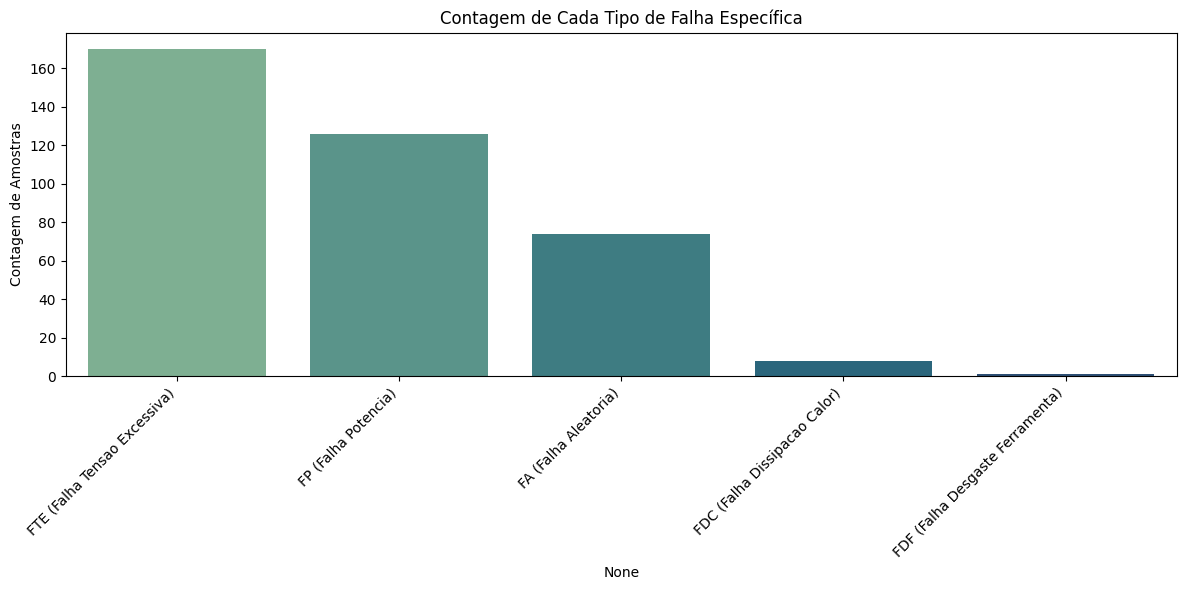


Gráfico 3: Distribuição das Variáveis Numéricas


/tmp/ipython-input-937181592.py:39: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_train[numeric_features].hist(bins=30, color='skyblue', layout=(2, 3), ax=plt.gca())


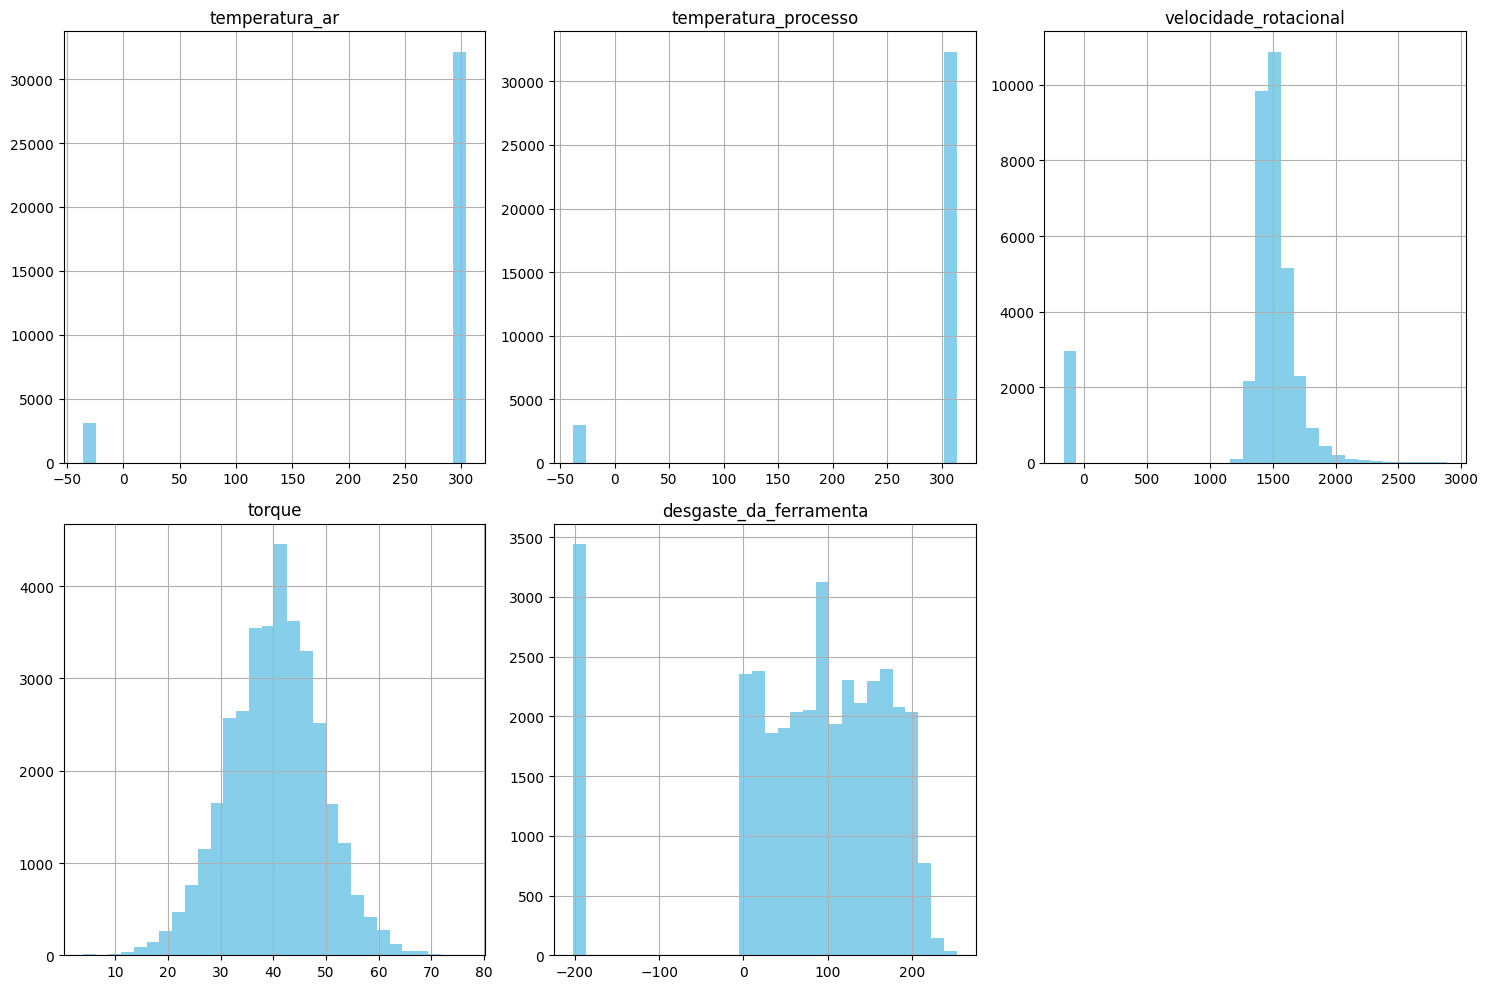


Gráfico 4: Matriz de Correlação entre Variáveis


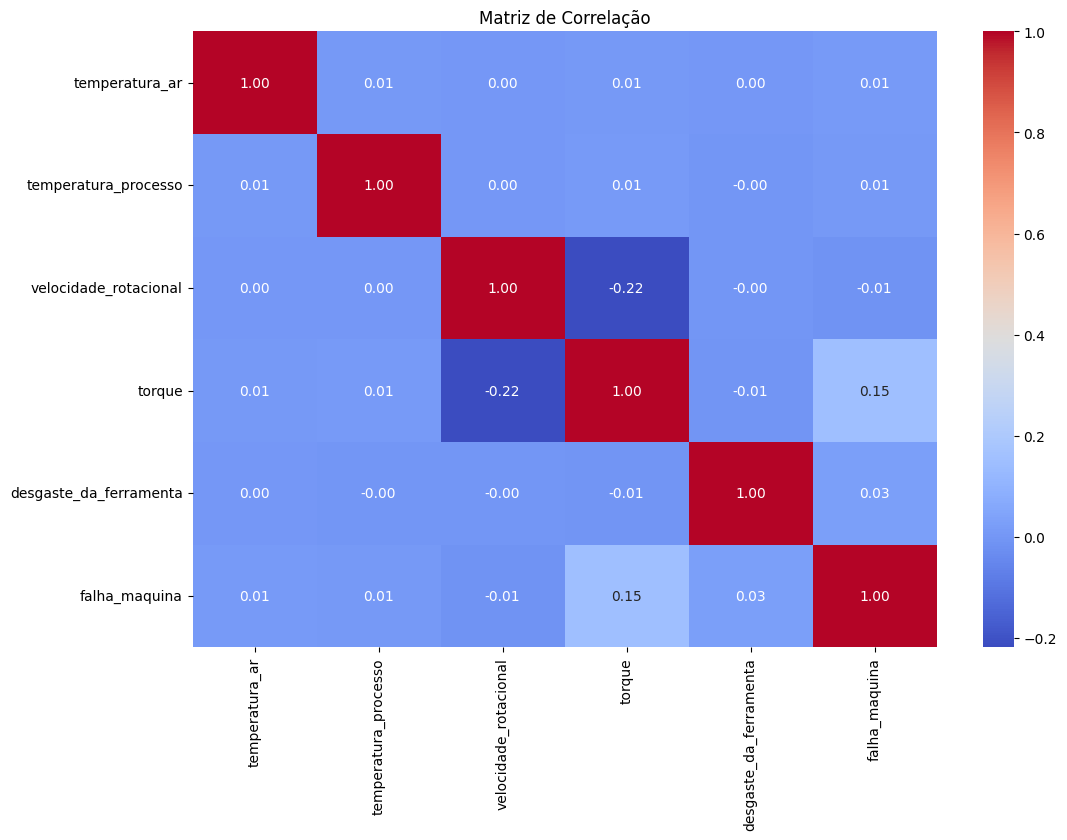

--------------------------------------------------
Análise Exploratória concluída.


In [34]:
# Célula 5: Análise Exploratória de Dados (EDA) com Dados Limpos

print("Iniciando a Análise Exploratória de Dados...")
print("-" * 50)


# 1. Análise do Desbalanceamento de Classes
print("\nGráfico 1: Distribuição da 'falha_maquina'")
falha_counts = df_train['falha_maquina'].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(x=falha_counts.index, y=falha_counts.values, palette='viridis')
plt.title('Distribuição da Falha Geral da Máquina')
plt.ylabel('Contagem de Amostras')
plt.xticks([0, 1], ['Sem Falha', 'Com Falha'])
plt.show()

# 2. Contagem por Tipo Específico de Falha
print("\nGráfico 2: Contagem por Tipo Específico de Falha")
target_cols = [
    'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)'
]
falhas_especificas = df_train[target_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=falhas_especificas.index, y=falhas_especificas.values, palette='crest')
plt.title('Contagem de Cada Tipo de Falha Específica')
plt.ylabel('Contagem de Amostras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 3. Distribuição das Variáveis Numéricas
print("\nGráfico 3: Distribuição das Variáveis Numéricas")
# A lista 'numeric_features' foi definida na célula de limpeza
plt.figure(figsize=(15, 10))
df_train[numeric_features].hist(bins=30, color='skyblue', layout=(2, 3), ax=plt.gca())
plt.tight_layout()
plt.show()


# 4. Matriz de Correlação
print("\nGráfico 4: Matriz de Correlação entre Variáveis")
# Vamos correlacionar as features numéricas com a falha geral
cols_for_corr = numeric_features + ['falha_maquina']
correlation_matrix = df_train[cols_for_corr].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

print("-" * 50)
print("Análise Exploratória concluída.")

Pré-processamento e Divisão dos Dados

In [35]:
# Célula 6: Pré-processamento e Divisão dos Dados

print("Iniciando o pré-processamento e a divisão dos dados...")
print("-" * 50)


# 1. Definir as colunas de features (X) e de targets (y)
features = ['tipo', 'temperatura_ar', 'temperatura_processo', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
target_cols = [
    'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)'
]

X = df_train[features]
y = df_train[target_cols]


# 2. Criar o pipeline de pré-processamento com ColumnTransformer
# Esta ferramenta aplica diferentes transformações para diferentes tipos de colunas.

# Separa as features em dois grupos: numéricas e categóricas
categorical_features = ['tipo']
numerical_features = ['temperatura_ar', 'temperatura_processo', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

preprocessor = ColumnTransformer(
    transformers=[
        # Etapa 'num': Aplica StandardScaler às colunas numéricas
        ('num', StandardScaler(), numerical_features),
        # Etapa 'cat': Aplica OneHotEncoder à coluna categórica
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# 3. Dividir os dados em conjuntos de Treino e Validação
# Usamos 80% para treino e 20% para validação.
# 'stratify' garante que a proporção de falhas seja a mesma em ambos os conjuntos.
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_train['falha_maquina']
)

print("Pipeline de pré-processamento criado.")
print("Dados divididos em conjuntos de treino e validação:")
print(f" - Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f" - Tamanho do conjunto de validação (X_val): {X_val.shape}")

print("-" * 50)
print("Pré-processamento concluído. Os dados estão prontos para o treinamento.")

Iniciando o pré-processamento e a divisão dos dados...
--------------------------------------------------
Pipeline de pré-processamento criado.
Dados divididos em conjuntos de treino e validação:
 - Tamanho do conjunto de treino (X_train): (28208, 6)
 - Tamanho do conjunto de validação (X_val): (7052, 6)
--------------------------------------------------
Pré-processamento concluído. Os dados estão prontos para o treinamento.


Treinamento do Modelo

In [36]:
# Célula 7: Treinamento do Modelo de Machine Learning

print("Iniciando a fase de treinamento do modelo...")
print("-" * 50)


# 1. Definir o classificador base
# Usamos RandomForestClassifier, um modelo robusto para dados tabulares.
# 'class_weight="balanced"' ajuda o modelo a lidar com o desbalanceamento de classes.
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# 2. Definir a estratégia para o problema multirrótulo
# O MultiOutputClassifier treina um classificador separado para cada tipo de falha.
multi_output_model = MultiOutputClassifier(estimator=base_classifier, n_jobs=-1)

# 3. Criar o pipeline final que junta o pré-processamento e o modelo
# Este é o nosso sistema completo e encapsulado.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', multi_output_model)])

# 4. Treinar o modelo com os dados de treino!
# O comando .fit() inicia o processo de aprendizado.
print("Treinando o modelo com os dados de treino... Isso pode levar alguns instantes.")
model_pipeline.fit(X_train, y_train)

print("-" * 50)
print("Treinamento concluído!")

Iniciando a fase de treinamento do modelo...
--------------------------------------------------
Treinando o modelo com os dados de treino... Isso pode levar alguns instantes.
--------------------------------------------------
Treinamento concluído!


Avaliação do Modelo

In [37]:
# Célula 8: Avaliação do Desempenho no Conjunto de Validação

print("Iniciando a avaliação do modelo no conjunto de validação...")
print("-" * 50)


# 1. Fazer previsões nos dados de validação
y_pred_val = model_pipeline.predict(X_val)

# 2. Gerar o Relatório de Classificação para análise de métricas
print("Relatório de Classificação:")
print(classification_report(y_val, y_pred_val, target_names=target_cols, zero_division=0))


# 3. Calcular a métrica AUC-ROC de forma robusta
# (Lida com o caso de falhas extremamente raras)
print("Calculando AUC-ROC Score...")
y_proba_val = model_pipeline.predict_proba(X_val)

probabilities = []
for p in y_proba_val:
    if p.shape[1] == 2:
        probabilities.append(p[:, 1]) # Probabilidade da classe 1 (falha)
    else:
        # Se só há uma coluna, a prob da classe 1 é sempre 0.
        probabilities.append(np.zeros(p.shape[0]))

y_proba_val_reformatted = np.array(probabilities).T

try:
    auc_score = roc_auc_score(y_val, y_proba_val_reformatted, average='weighted')
    print(f"\nAUC-ROC Score (Média Ponderada): {auc_score:.4f}")
except ValueError as e:
    print(f"\nNão foi possível calcular o AUC Score. Motivo: {e}")

print("-" * 50)
print("Avaliação concluída.")

Iniciando a avaliação do modelo no conjunto de validação...
--------------------------------------------------
Relatório de Classificação:
                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00         1
   FDC (Falha Dissipacao Calor)       0.00      0.00      0.00         2
            FP (Falha Potencia)       0.78      0.30      0.44        23
   FTE (Falha Tensao Excessiva)       0.45      0.15      0.22        34
           FA (Falha Aleatoria)       0.00      0.00      0.00        22

                      micro avg       0.55      0.15      0.23        82
                      macro avg       0.25      0.09      0.13        82
                   weighted avg       0.41      0.15      0.21        82
                    samples avg       0.00      0.00      0.00        82

Calculando AUC-ROC Score...

AUC-ROC Score (Média Ponderada): 0.8237
--------------------------------------------------
Avaliaçã

In [40]:
# Célula 8: Avaliação do Desempenho no Conjunto de Validação

print("Iniciando a avaliação do modelo no conjunto de validação...")
print("-" * 50)


# 1. Fazer previsões nos dados de validação
y_pred_val = model_pipeline.predict(X_val)

# 2. Gerar o Relatório de Classificação para análise de métricas
print("Relatório de Classificação:")
print(classification_report(y_val, y_pred_val, target_names=target_cols, zero_division=0))


# 3. Calcular a métrica AUC-ROC de forma robusta
# (Lida com o caso de falhas extremamente raras)
print("Calculando AUC-ROC Score...")
y_proba_val = model_pipeline.predict_proba(X_val)

probabilities = []
for p in y_proba_val:
    if p.shape[1] == 2:
        probabilities.append(p[:, 1]) # Probabilidade da classe 1 (falha)
    else:
        # Se só há uma coluna, a prob da classe 1 é sempre 0.
        probabilities.append(np.zeros(p.shape[0]))

y_proba_val_reformatted = np.array(probabilities).T

try:
    auc_score = roc_auc_score(y_val, y_proba_val_reformatted, average='weighted')
    print(f"\nAUC-ROC Score (Média Ponderada): {auc_score:.4f}")
except ValueError as e:
    print(f"\nNão foi possível calcular o AUC Score. Motivo: {e}")

print("-" * 50)
print("Avaliação concluída.")

Iniciando a avaliação do modelo no conjunto de validação...
--------------------------------------------------
Relatório de Classificação:
                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00         1
   FDC (Falha Dissipacao Calor)       0.00      0.00      0.00         2
            FP (Falha Potencia)       0.78      0.30      0.44        23
   FTE (Falha Tensao Excessiva)       0.45      0.15      0.22        34
           FA (Falha Aleatoria)       0.00      0.00      0.00        22

                      micro avg       0.55      0.15      0.23        82
                      macro avg       0.25      0.09      0.13        82
                   weighted avg       0.41      0.15      0.21        82
                    samples avg       0.00      0.00      0.00        82

Calculando AUC-ROC Score...

AUC-ROC Score (Média Ponderada): 0.8237
--------------------------------------------------
Avaliaçã

In [39]:
# Célula 9: Otimização de Hiperparâmetros com GridSearchCV

from sklearn.model_selection import GridSearchCV

print("Iniciando a otimização de hiperparâmetros com GridSearchCV...")
print("-" * 50)

# 1. Definir o pipeline (o mesmo de antes, sem o treinamento)
# Nosso pipeline já contém o pré-processador e a estrutura do modelo.
base_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
multi_output_model = MultiOutputClassifier(estimator=base_classifier, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', multi_output_model)])

# 2. Definir a grade de parâmetros para testar (uma grade "curta")
# Usamos a sintaxe 'nome_do_passo__parametro_do_estimador__parametro_final'
param_grid = {
    'classifier__estimator__n_estimators': [100, 150],       # Número de árvores na floresta
    'classifier__estimator__max_depth': [10, 20],           # Profundidade máxima de cada árvore
    'classifier__estimator__min_samples_leaf': [5, 10]      # Mínimo de amostras em um nó folha
}

# 3. Configurar o GridSearchCV
# 'cv=3' significa que ele usará validação cruzada com 3 folds.
# 'scoring' define a métrica que ele tentará otimizar. 'f1_weighted' é boa para nosso caso.
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1, # Usa todos os processadores disponíveis
    verbose=1  # Mostra o progresso
)

# 4. Executar a busca pelos melhores parâmetros
print("Executando a busca em grade... Isso pode levar vários minutos.")
grid_search.fit(X_train, y_train)

# 5. Exibir os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)


# 6. Avaliar o MELHOR modelo encontrado pelo GridSearch
print("\n--- Avaliação do Modelo Otimizado no Conjunto de Validação ---")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val)

print("\nRelatório de Classificação (Modelo Otimizado):")
print(classification_report(y_val, y_pred_best, target_names=target_cols, zero_division=0))

print("-" * 50)
print("Otimização e avaliação concluídas.")

Iniciando a otimização de hiperparâmetros com GridSearchCV...
--------------------------------------------------
Executando a busca em grade... Isso pode levar vários minutos.
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Melhores parâmetros encontrados:
{'classifier__estimator__max_depth': 20, 'classifier__estimator__min_samples_leaf': 5, 'classifier__estimator__n_estimators': 100}

--- Avaliação do Modelo Otimizado no Conjunto de Validação ---

Relatório de Classificação (Modelo Otimizado):
                                 precision    recall  f1-score   support

FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00         1
   FDC (Falha Dissipacao Calor)       0.00      0.00      0.00         2
            FP (Falha Potencia)       0.54      0.61      0.57        23
   FTE (Falha Tensao Excessiva)       0.38      0.53      0.44        34
           FA (Falha Aleatoria)       0.00      0.00      0.00        22

                      micro avg       0.42     

In [42]:
# Célula 10: Geração do Arquivo de Submissão Final com o Modelo Otimizado (Corrigida)

print("Iniciando a etapa final: Geração do arquivo de submissão...")
print("-" * 50)

# 1. Fazer o upload do arquivo de teste
print("Por favor, faça o upload do arquivo 'bootcamp_test.csv'")
try:
    uploaded_test = files.upload()
    test_filename = list(uploaded_test.keys())[0]
    df_test = pd.read_csv(io.BytesIO(uploaded_test[test_filename]))
    print(f"\nArquivo '{test_filename}' carregado com sucesso.")

    # 2. Limpar os dados de teste (aplicar as mesmas transformações do treino)
    print("\nLimpando os dados de teste...")
    for col in numeric_features:
        # Preenche valores faltantes com a MEDIANA DO CONJUNTO DE TREINO para evitar data leakage
        mediana = df_train[col].median()
        df_test[col].fillna(mediana, inplace=True)
    print("Limpeza concluída.")


    # 3. Usar o MELHOR modelo encontrado pelo GridSearchCV para prever as PROBABILIDADES
    print("\nUsando o modelo otimizado para gerar as previsões...")
    # Certifique-se de que a variável do seu melhor modelo está correta aqui (ex: grid_search.best_estimator_ ou grid_search_lgbm.best_estimator_)
    best_model = grid_search.best_estimator_ # Use grid_search_lgbm se o LightGBM foi o melhor
    X_test = df_test[features]

    test_probabilities = best_model.predict_proba(X_test)


    # 4. Criar e formatar o DataFrame de submissão
    submission_df = pd.DataFrame()
    submission_df['id'] = df_test['id']

    probabilities_submission = []
    for p in test_probabilities:
        if p.shape[1] == 2:
            probabilities_submission.append(p[:, 1])
        else:
            probabilities_submission.append(np.zeros(p.shape[0]))

    for i, col in enumerate(target_cols):
        submission_df[col] = probabilities_submission[i]


    # 5. Salvar e baixar o arquivo de submissão final
    submission_df.to_csv('submission.csv', index=False)
    print("\nArquivo 'submission.csv' final gerado com sucesso!")
    display(submission_df.head())

    print("\nIniciando o download do arquivo...")
    files.download('submission.csv')
    print("-" * 50)
    print("Processo concluído!")

except Exception as e:
    print(f"\nOcorreu um erro. Certifique-se de que o upload foi concluído. Erro: {e}")

Iniciando a etapa final: Geração do arquivo de submissão...
--------------------------------------------------
Por favor, faça o upload do arquivo 'bootcamp_test.csv'


Saving bootcamp_test.csv to bootcamp_test (1).csv

Arquivo 'bootcamp_test (1).csv' carregado com sucesso.

Limpando os dados de teste...
Limpeza concluída.

Usando o modelo otimizado para gerar as previsões...


/tmp/ipython-input-951294444.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col].fillna(mediana, inplace=True)



Arquivo 'submission.csv' final gerado com sucesso!


,id,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,35260,0.0,0.0,0.0,0.0,0.000000
1,35261,0.0,0.0,0.0,0.0,0.000000
2,35262,0.0,0.0,0.0,0.0,0.000000
3,35263,0.0,0.0,0.0,0.0,0.029658
4,35264,0.0,0.0,0.0,0.0,0.009963



Iniciando o download do arquivo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------------
Processo concluído!


In [51]:
from google.colab import files
import pandas as pd

# faz o upload manual do arquivo
uploaded = files.upload()

# pega o nome do arquivo enviado
df = pd.read_csv('submission.csv')



Saving submission.csv to submission.csv


Saving submission.csv to submission (1).csv


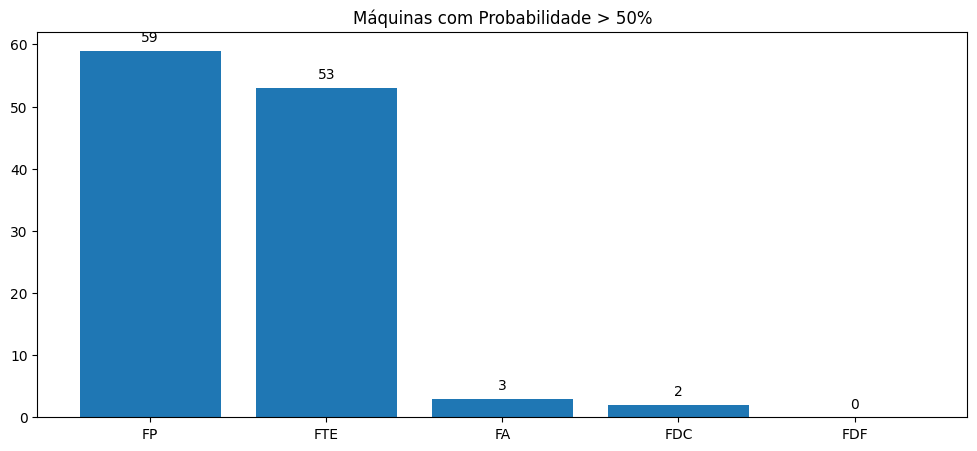

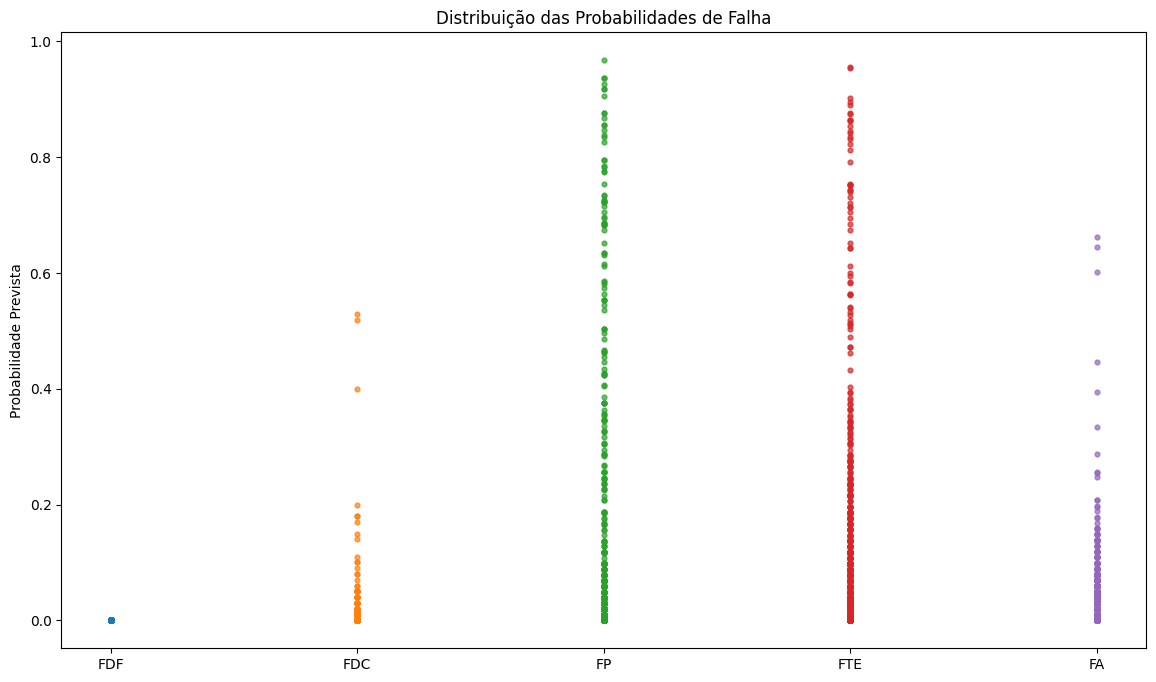

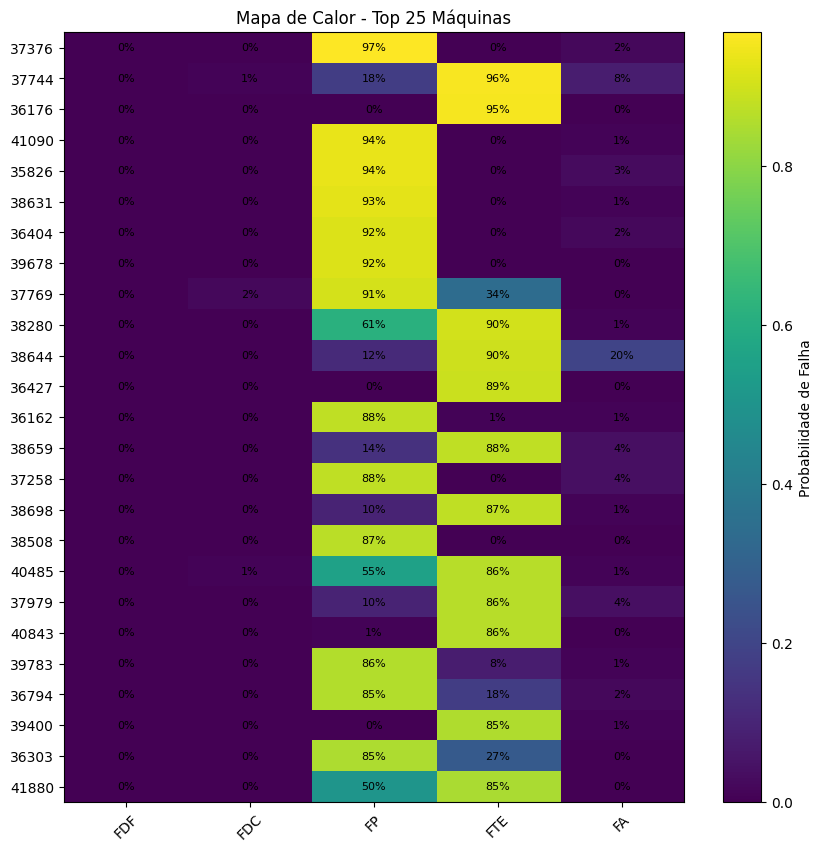

In [53]:
# Célula 11 — Recriar gráficos a partir do CSV (versão Google Colab)

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# --- 1) Upload do arquivo CSV ---
uploaded = files.upload()  # escolha o submission.csv
df = pd.read_csv('submission.csv')   # arquivo sobe para /content/

# --- 2) Detectar colunas das classes e de ID ---
aliases = {
    'FDF': [r'^FDF$', r'FDF.*'],
    'FDC': [r'^FDC$', r'FDC.*'],
    'FP' : [r'^FP$',  r'FP.*'],
    'FTE': [r'^FTE$', r'FTE.*'],
    'FA' : [r'^FA$',  r'FA.*'],
}

id_candidates = ['id','ID','machine_id','Machine_ID','serial_number','serial']
id_col = None
for c in df.columns:
    if c in id_candidates or c.lower() in [x.lower() for x in id_candidates]:
        id_col = c
        break
if id_col is None:
    id_col = 'row_id'
    df[id_col] = np.arange(1, len(df)+1)

def find_col(patterns):
    for patt in patterns:
        rx = re.compile(patt, flags=re.IGNORECASE)
        for col in df.columns:
            if rx.match(str(col)):
                return col
    return None

class_cols = {}
for k, pats in aliases.items():
    class_cols[k] = find_col(pats)

for k, col in class_cols.items():
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)

# --- 3) Long format para gráficos ---
df_long = pd.concat([
    pd.DataFrame({id_col: df[id_col], 'tipo': k, 'prob': df[col].clip(0,1)})
    for k,col in class_cols.items()
], ignore_index=True)

# --- 4) Gráfico de barras (prob > 0.5) ---
counts = (df_long.assign(gt50 = df_long['prob'] > 0.5)
                  .groupby('tipo')['gt50'].sum()
                  .reindex(['FP','FTE','FA','FDC','FDF']))
plt.figure(figsize=(12,5))
bars = plt.bar(counts.index, counts.values)
plt.title('Máquinas com Probabilidade > 50%')
for rect,val in zip(bars, counts.values):
    plt.text(rect.get_x()+rect.get_width()/2, rect.get_height()+1,
             f'{int(val)}', ha='center', va='bottom')
plt.show()

# --- 5) Gráfico de dispersão ---
plt.figure(figsize=(14,8))
tipos_ord = ['FDF','FDC','FP','FTE','FA']
x_pos = {t:i for i,t in enumerate(tipos_ord)}
for tipo in tipos_ord:
    sub = df_long[df_long['tipo']==tipo]
    plt.scatter(np.full(len(sub), x_pos[tipo]), sub['prob'], s=12, alpha=0.7)
plt.xticks(list(x_pos.values()), list(x_pos.keys()))
plt.ylabel('Probabilidade Prevista')
plt.title('Distribuição das Probabilidades de Falha')
plt.show()

# --- 6) Heatmap Top 25 ---
df['max_risco'] = df[[class_cols[k] for k in tipos_ord]].max(axis=1)
top = (df[[id_col]+[class_cols[k] for k in tipos_ord]]
       .assign(_max=df['max_risco'])
       .sort_values('_max', ascending=False)
       .head(25)
       .drop(columns=['_max']))
heat_values = top[[class_cols[k] for k in tipos_ord]].to_numpy()

plt.figure(figsize=(10,10))
im = plt.imshow(heat_values, aspect='auto', interpolation='nearest')
plt.yticks(range(len(top)), top[id_col].astype(str).tolist())
plt.xticks(range(len(tipos_ord)), tipos_ord, rotation=45)
plt.colorbar(im).set_label('Probabilidade de Falha')
plt.title('Mapa de Calor - Top 25 Máquinas')
for i in range(heat_values.shape[0]):
    for j in range(heat_values.shape[1]):
        plt.text(j,i,f'{heat_values[i,j]*100:.0f}%', ha='center', va='center', fontsize=8)
plt.show()
